# Purpose

This notebook looks at current satellite orbit parameters with the aim to determine EO coverage in the polar regions.

### Get the data

Begin by downloading the latest satellite data from the Union of Concerned Scientists.
http://www.ucsusa.org/satellite_database 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [2]:
# load the data and check the column names

df = pd.read_csv('./UCS-Satellite-Database-5-1-2023.txt', encoding='latin-1', delimiter="\t", index_col=None, thousands=',')
df.columns = df.columns.str.strip()
print(df.columns)

Index(['Name of Satellite, Alternate Names',
       'Current Official Name of Satellite', 'Country/Org of UN Registry',
       'Country of Operator/Owner', 'Operator/Owner', 'Users', 'Purpose',
       'Detailed Purpose', 'Class of Orbit', 'Type of Orbit',
       'Longitude of GEO (degrees)', 'Perigee (km)', 'Apogee (km)',
       'Eccentricity', 'Inclination (degrees)', 'Period (minutes)',
       'Launch Mass (kg.)', 'Dry Mass (kg.)', 'Power (watts)',
       'Date of Launch', 'Expected Lifetime (yrs.)', 'Contractor',
       'Country of Contractor', 'Launch Site', 'Launch Vehicle',
       'COSPAR Number', 'NORAD Number', 'Comments', 'Unnamed: 28',
       'Source Used for Orbital Data', 'Source', 'Source.1', 'Source.2',
       'Source.3', 'Source.4', 'Source.5', 'Source.6', 'Unnamed: 37',
       'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41',
       'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45',
       'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49',
  

## Do some data cleanup

Use the Kaggle Notebook for guidance on data cleaning UCS data.
https://www.kaggle.com/code/luisemiliani/exploring-the-ucs-satellite-database#Data-Source:-the-Union-of-Concerned-Scientists-(UCS)-satellite-database 

In [3]:
# Drop unused columns and convert datatypes where possible.

df.drop(list(df.filter(regex='Source|Unnamed')), axis=1, inplace=True)
df.convert_dtypes().head(3)

,"Name of Satellite, Alternate Names",Current Official Name of Satellite,Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,...,Power (watts),Date of Launch,Expected Lifetime (yrs.),Contractor,Country of Contractor,Launch Site,Launch Vehicle,COSPAR Number,NORAD Number,Comments
0,1HOPSAT-TD (1st-generation High Optical Perfor...,1HOPSAT-TD,NR,USA,Hera Systems,Commercial,Earth Observation,Infrared Imaging,LEO,Non-Polar Inclined,...,<NA>,12/11/19,0.5,Hera Systems,USA,Satish Dhawan Space Centre,PSLV,2019-089H,44859,Pathfinder for planned earth observation const...
1,AAC AIS-Sat1 (Kelpie 1),AAC AIS-Sat1Ê(Kelpie 1),United Kingdom,United Kingdom,AAC Clyde Space,Commercial,Earth Observation,Automatic Identification System (AIS),LEO,Sun-Synchronous,...,<NA>,1/3/23,<NA>,AAC Clyde Space,Sweden/UK/USA/Netherlands,Cape Canaveral,Falcon 9,2023-001DC,55107,Provide AIS information to Orbcomm.
2,Aalto-1,Aalto-1,Finland,Finland,Aalto University,Civil,Technology Development,<NA>,LEO,Sun-Synchronous,...,4.50,6/23/17,2.0,Aalto University,Finland,Satish Dhawan Space Centre,PSLV,2017-036L,42775,Technology development and education.


In [4]:
# How many satellites without a name are in the dataset?

text = df['Name of Satellite, Alternate Names'].isna().sum()
print(f'There are {text} satellites without a name in the dataset.')
# drop any rows with missing values in the 'Name of Satellite, Alternate Names' column
df.dropna(subset=['Name of Satellite, Alternate Names'], inplace=True)

There are 2 satellites without a name in the dataset.


In [5]:
# remove extraneous spaces that result in multiple copies of a category

print(' Users. Labels before cleaning : {}'.format(len( df['Users'].unique() ) ) )
print(' Purpose. Labels before cleaning : {}'.format(len( df['Purpose'].unique() ) ) )  
print(' Class of Orbit. Labels before cleaning : {}'.format(len( df['Class of Orbit'].unique() ) ) )  
print(' Type of Orbit. Labels before cleaning : {}'.format(len( df['Type of Orbit'].unique() ) ) )  

df['Users']=df['Users'].str.strip()
df['Purpose']=df['Purpose'].str.strip()
df['Class of Orbit']=df['Class of Orbit'].str.strip()
df['Type of Orbit']=df['Type of Orbit'].str.strip()

print(' -----------------------------------------------------------------------------')
print(' Users. Labels AFTER cleaning : {}'.format(len( df['Users'].unique() ) ) )
print(' Purpose. Labels AFTER cleaning : {}'.format(len( df['Purpose'].unique() ) ) )  
print(' Class of Orbit. Labels AFTER cleaning : {}'.format(len( df['Class of Orbit'].unique() ) ) )
print(' Type of Orbit. Labels AFTER cleaning : {}'.format(len( df['Type of Orbit'].unique() ) ) )  

 Users. Labels before cleaning : 20
 Purpose. Labels before cleaning : 31
 Class of Orbit. Labels before cleaning : 5
 Type of Orbit. Labels before cleaning : 11
 -----------------------------------------------------------------------------
 Users. Labels AFTER cleaning : 17
 Purpose. Labels AFTER cleaning : 30
 Class of Orbit. Labels AFTER cleaning : 5
 Type of Orbit. Labels AFTER cleaning : 11


In [6]:
# Make all the orbit data uppercase to properly match

df['Class of Orbit'] = df['Class of Orbit'].str.upper().astype('category')
df['Type of Orbit'] = df['Type of Orbit'].str.upper().astype('category')

In [7]:
# Make the date of launch a datetime object and check any NAN values.
# N.B. Satellogic have two 

parsed_date_of_launch = pd.to_datetime(df['Date of Launch'], errors='coerce').sort_values()
# determine if there are any data points not correctly formatted
print(parsed_date_of_launch.loc[np.isnat(parsed_date_of_launch)])

240    NaT
349    NaT
7186   NaT
Name: Date of Launch, dtype: datetime64[ns]


/tmp/ipykernel_70197/1092443254.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed_date_of_launch = pd.to_datetime(df['Date of Launch'], errors='coerce').sort_values()


In [8]:
# Ugly data

df.loc[ np.isnat(parsed_date_of_launch), ['Name of Satellite, Alternate Names','NORAD Number','Date of Launch'] ]

,"Name of Satellite, Alternate Names",NORAD Number,Date of Launch
240,BlackSky Global 5,55983.0,NaN
349,Cicero-8 (Community Initiative for Cellular Ea...,43737.0,11/29/018
7186,Tianmu-1 01,55134.0,1/9//2023


In [9]:
# Fix the dates based on secondary sources

df.loc[ np.isnat(parsed_date_of_launch), 'Date of Launch'] = pd.to_datetime(["03/24/2023", "11/29/2018", "09/01/2023"])
df.loc[ np.isnat(parsed_date_of_launch), ['Name of Satellite, Alternate Names','NORAD Number','Date of Launch'] ]

,"Name of Satellite, Alternate Names",NORAD Number,Date of Launch
240,BlackSky Global 5,55983.0,2023-03-24 00:00:00
349,Cicero-8 (Community Initiative for Cellular Ea...,43737.0,2018-11-29 00:00:00
7186,Tianmu-1 01,55134.0,2023-09-01 00:00:00


In [10]:
# Make the data the index of the dataframe and sort it chronologically
df['Date of Launch'] = pd.to_datetime(df['Date of Launch'])
df.set_index( df['Date of Launch'], inplace=True )
df.sort_index(axis=0, inplace=True, ascending=False)
df.head(2)

/tmp/ipykernel_70197/2222867912.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date of Launch'] = pd.to_datetime(df['Date of Launch'])


,"Name of Satellite, Alternate Names",Current Official Name of Satellite,Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,...,Power (watts),Date of Launch,Expected Lifetime (yrs.),Contractor,Country of Contractor,Launch Site,Launch Vehicle,COSPAR Number,NORAD Number,Comments
Date of Launch,,,,,,,,,,,,,,,,,,,,,
2023-09-01,Tianmu-1 01,Tianmu-1 01,NR (9/23),China,Xiyong Microelectrics Park,Commercial,Meteorological,NaN,LEO,SUN-SYNCHRONOUS,...,NaN,2023-09-01,2.0,China Aerospace Science and Technology Corp. (...,China,Jiuquan Satellite Launch Center,Ceres,2023-003B,55134.0,https://www.newspace.im/constellations/xyong-m...
2023-04-27,Starlink-5552,Starlink-5552,USA,USA,SpaceX,Commercial,Communications,NaN,LEO,SUN-SYNCHRONOUS,...,NaN,2023-04-27,NaN,SpaceX,USA,Cape Canaveral,Falcon 9,2023-058Y,56339.0,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7560 entries, 2023-09-01 to 1974-11-15
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Name of Satellite, Alternate Names  7560 non-null   object        
 1   Current Official Name of Satellite  7560 non-null   object        
 2   Country/Org of UN Registry          7559 non-null   object        
 3   Country of Operator/Owner           7560 non-null   object        
 4   Operator/Owner                      7560 non-null   object        
 5   Users                               7560 non-null   object        
 6   Purpose                             7560 non-null   object        
 7   Detailed Purpose                    1254 non-null   object        
 8   Class of Orbit                      7560 non-null   category      
 9   Type of Orbit                       6909 non-null   category      
 10  Longit

In [12]:
# How many satellites operate in the North

northern_satellites = df[df['Inclination (degrees)'] >  60]
northern_satellites['Type of Orbit'].count()

2949

In [13]:
# What types of orbits are used by satellites? 
# N.B. Molniya are typically used for communications and monitoring in high latitudes

df[['Class of Orbit', 'Type of Orbit']].value_counts()

Class of Orbit  Type of Orbit             
LEO             NON-POLAR INCLINED            3942
                SUN-SYNCHRONOUS               1688
                POLAR                         1096
MEO             NON-POLAR INCLINED              98
ELLIPTICAL      MOLNIYA                         23
MEO             EQUATORIAL                      20
LEO             EQUATORIAL                      18
ELLIPTICAL      DEEP HIGHLY ECCENTRIC            9
LEO             ELLIPTICAL                       5
ELLIPTICAL      SUN-SYNCHRONOUS                  4
                NON-POLAR INCLINED               2
LEO             SUN-SYNCHRONOUS NEAR POLAR       2
ELLIPTICAL      CISLUNAR                         1
LEO             RETROGRADE                       1
Name: count, dtype: int64

In [14]:
molniya_orbits = df[df['Type of Orbit'] == 'MOLNIYA']
countries = molniya_orbits[['Country of Operator/Owner', 'Detailed Purpose']].value_counts()
countries 


Country of Operator/Owner  Detailed Purpose       
Russia                     Early Warning              5
USA                        Electronic Intelligence    4
                           Data Relay                 2
Name: count, dtype: int64

In [15]:
# Check for outliers in the data

(df.groupby(['Class of Orbit'])
 .agg({'Apogee (km)': ['min', 'max', 'count'],'Perigee (km)': ['min', 'max', 'count']}
))

/tmp/ipykernel_70197/612075391.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (df.groupby(['Class of Orbit'])


Apogee (km)                 Perigee (km)               
                       min       max count          min      max count
Class of Orbit                                                        
ELLIPTICAL           689.0  330000.0    59        216.0  62200.0    59
GEO                35170.0  353798.0   590        198.0  37782.0   590
LEO                   49.0   36343.0  6761        150.0  36236.0  6761
MEO                 1999.0   23618.0   143       1992.0  23551.0   143

In [16]:
## identify outliers in the Apogee and Perigee columns
isOutApogeePerigeeLEO_idx = ((df['Class of Orbit'] == 'LEO') & (df['Apogee (km)'] > 2000)) | ((df['Class of Orbit'] == 'LEO') & (df['Perigee (km)'] > 2000))
#isOutPerigee_idx = ( UCSDB['Class of Orbit'] == 'LEO') & ( UCSDB['Perigee (km)'] >2000 )
isUnderApogeeLEO_idx = ( df['Class of Orbit'] == 'LEO') & ( df['Apogee (km)'] < 100 )

print(' Number of outliers in columns Apogee, Perigee, for LEO satellites')
print('-------------------------------------------------------------------------')
print(' Number of data points with value more than 2000 km in Apogee col: {}'.format(isOutApogeePerigeeLEO_idx.sum()))
print(' Number of data points with value less than 100 km in Apogee col: {}'.format(isUnderApogeeLEO_idx.sum()))

 Number of outliers in columns Apogee, Perigee, for LEO satellites
-------------------------------------------------------------------------
 Number of data points with value more than 2000 km in Apogee col: 2
 Number of data points with value less than 100 km in Apogee col: 1


In [17]:
# Fix the orbit data errors

df[isUnderApogeeLEO_idx][['Name of Satellite, Alternate Names','NORAD Number', 'Apogee (km)', 'Perigee (km)']]
# correct Apogee and Perigee for satellite with NORAD number 49390
df.loc[isUnderApogeeLEO_idx,['Apogee (km)', 'Perigee (km)'] ]= [498,496]
df[isUnderApogeeLEO_idx][['Name of Satellite, Alternate Names','NORAD Number','Class of Orbit','Apogee (km)', 'Perigee (km)']]

,"Name of Satellite, Alternate Names",NORAD Number,Class of Orbit,Apogee (km),Perigee (km)
Date of Launch,,,,,
2021-11-06,Yaogan 35-5-1,49390.0,LEO,498.0,496.0


In [18]:
## identify outliers in the Apogee and Perigee columns for GEO satellites
isOutApogeePerigeeGEO_idx =( ( df['Class of Orbit'] == 'GEO') & ( df['Apogee (km)'] >38000 ) ) | ( ( df['Class of Orbit'] == 'GEO') & ( df['Perigee (km)'] >38000 ) )
isUnderApogeeGEO_idx = ( ( df['Class of Orbit'] == 'GEO') & ( df['Apogee (km)'] < 35500 ) ) | ( ( df['Class of Orbit'] == 'GEO') & ( df['Perigee (km)'] <35500 ) )

print(' Number of outliers in columns Apogee, Perigee, for GEO satellites')
print('-------------------------------------------------------------------------')
print(' Number of data points with value more than 38000 km in Apogee or Perigee col: {}'.format(isOutApogeePerigeeGEO_idx.sum()))
print(' Number of data points with value less than 35500 km in Apogee or Perigee col: {}'.format(isUnderApogeeGEO_idx.sum()))


 Number of outliers in columns Apogee, Perigee, for GEO satellites
-------------------------------------------------------------------------
 Number of data points with value more than 38000 km in Apogee or Perigee col: 9
 Number of data points with value less than 35500 km in Apogee or Perigee col: 17


In [19]:
# GOES is interesting because it is a geostationary orbit satellite.

df[isUnderApogeeGEO_idx][['Name of Satellite, Alternate Names','NORAD Number', 'Apogee (km)', 'Perigee (km)']]

,"Name of Satellite, Alternate Names",NORAD Number,Apogee (km),Perigee (km)
Date of Launch,,,,
2021-12-19,Turksat 5B,50212.0,68931.0,198.0
2021-12-13,Express-AMU3,50001.0,52810.0,16324.0
2021-12-13,Express-AMU7,50002.0,52810.0,16334.0
2021-10-26,"QZS-1R (Quazi-Zenith Satellite System, Michibi...",49336.0,38964.0,32647.0
2021-10-24,SES-17,49332.0,44654.0,9403.0
2021-03-12,"Shiyan 9 (SY9, Experimental Satellite 9)",47851.0,35835.0,483.0
2019-12-24,Electro-L3,44903.0,35572.0,35372.0
2018-04-22,ESPASat ( 286),43446.0,35306.0,35244.0
2017-10-09,"QZS-4 (Quazi-Zenith Satellite System, Michibik...",42965.0,38943.0,32622.0


In [20]:
## identify outliers in the Apogee and Perigee columns
isOutApogeePerigeeELL_idx =( ( df['Class of Orbit'] == 'ELLIPTICAL') & ( df['Apogee (km)'] >200000 ) ) | ( ( df['Class of Orbit'] == 'ELLIPTICAL') & ( df['Perigee (km)'] >200000 ) )
isUnderApogeeELL_idx = ( df['Class of Orbit'] == 'ELLIPTICAL') & ( df['Apogee (km)'] < 250 ) | ( df['Class of Orbit'] == 'ELLIPTICAL') & ( df['Perigee (km)'] < 250 )

print(' Number of outliers in columns Apogee, Perigee, for ELLIPTICAL orbit satellites')
print('-------------------------------------------------------------------------')
print(' Number of data points with value more than 250000 km in Apogee col: {}'.format(isOutApogeePerigeeELL_idx.sum()))
print(' Number of data points with value less than 250 km in Apogee col: {}'.format(isUnderApogeeELL_idx.sum()))

 Number of outliers in columns Apogee, Perigee, for ELLIPTICAL orbit satellites
-------------------------------------------------------------------------
 Number of data points with value more than 250000 km in Apogee col: 3
 Number of data points with value less than 250 km in Apogee col: 5


In [21]:
# Save the cleaned dataset
df.to_csv('full_cleaned_UCS_05-01-2023.csv', index=True)

# Filter EO Satellites

In [22]:
# Filter the dataframe for the following purpose
geospatial_filter_list = [
    "Earth Observation",
    #"Technology Development",
    #"Navigation/Global Positioning",
    #"Technology Demonstration",
    "Earth Science",
    "Surveillance",
    #"Navigation/Regional Positioning",
    "Unknown",
    "Earth Observation/Navigation",
    #"Space Observation",
    "Earth Observation/Technology Development",
    "Meteorological",
    #"Communications/Maritime Tracking",
    "Earth/Space Observation",
    "Earth Observation",
    "Earth Observation/Communications",
    #"Mission Extension Technology",
    "Earth Observation/Communications/Space Science",
    "Earth Science/Earth Observation",
    #"Communications/Navigation",
    "Earth Observation/Space Science",
    "Earth Observation/Earth Science",
    #"Space Science/Technology Demonstration",
    #"Satellite Positioning"
]

# Filter the dataframe based on the geospatial_filter_list
df = df[df['Purpose'].isin(geospatial_filter_list)]

# Display the filtered dataframe
df.value_counts('Purpose')

Purpose
Earth Observation                                 1238
Earth Science                                       28
Surveillance                                        20
Unknown                                             10
Earth Observation/Navigation                         9
Earth Observation/Technology Development             7
Meteorological                                       6
Earth/Space Observation                              4
Earth Observation/Communications                     2
Earth Observation/Communications/Space Science       1
Earth Observation/Earth Science                      1
Earth Observation/Space Science                      1
Earth Science/Earth Observation                      1
Name: count, dtype: int64

# Get Orbit Tracks.

In [23]:
df.to_csv('filtered_UCS-Satellite-Database-5-1-2023.csv')

In [24]:
# Remove unused columns

df = df[['Current Official Name of Satellite',
       'Country of Operator/Owner', 'Operator/Owner', 'Users', 'Purpose',
       'Detailed Purpose', 'Class of Orbit', 'Type of Orbit', 'Inclination (degrees)',
       'Period (minutes)', 'COSPAR Number', 'NORAD Number', 'Comments']]

df.head(2)

,Current Official Name of Satellite,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,Inclination (degrees),Period (minutes),COSPAR Number,NORAD Number,Comments
Date of Launch,,,,,,,,,,,,,
2023-09-01,Tianmu-1 01,China,Xiyong Microelectrics Park,Commercial,Meteorological,NaN,LEO,SUN-SYNCHRONOUS,97.2,95.1,2023-003B,55134.0,https://www.newspace.im/constellations/xyong-m...
2023-04-15,DEWASAT-2,United Arab Emirates,Dubai Electricity and Water Authority (DEWA),Government,Earth Observation,Optical Imaging,LEO,SUN-SYNCHRONOUS,97.4,95.1,2023-054C,56180.0,UAE's first earth observation satellite.


In [25]:
# Number of EO Satellites with NO inclination
text = noInclination_idx =(df['Inclination (degrees)'].isna())
print(f'There are {text.sum()} satellites without an inclination in the dataset.')

# correct them
if text.sum() > 0:
    df.loc[noInclination_idx, 'Inclination (degrees)'] = pd.to_numeric(["97.38", "42.01", "97.30"])
df.loc[noInclination_idx, ['NORAD Number', 'Inclination (degrees)']]


There are 3 satellites without an inclination in the dataset.


,NORAD Number,Inclination (degrees)
Date of Launch,,
2023-04-15,56209.0,97.38
2023-03-24,55983.0,42.01
2023-01-15,55256.0,97.30


In [26]:
# How many satellites have an inclination greater than 60 degrees?

northern_satellites = df[df['Inclination (degrees)'] >  60]
northern_satellites['Purpose'].value_counts()

Purpose
Earth Observation                                 1014
Earth Science                                       28
Surveillance                                        17
Meteorological                                       6
Earth Observation/Technology Development             6
Earth/Space Observation                              4
Unknown                                              4
Earth Observation/Earth Science                      1
Earth Observation/Space Science                      1
Earth Science/Earth Observation                      1
Earth Observation/Communications/Space Science       1
Earth Observation/Communications                     1
Name: count, dtype: int64

In [27]:
northern_satellites.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1084 entries, 2023-09-01 to 1997-04-04
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   Current Official Name of Satellite  1084 non-null   object  
 1   Country of Operator/Owner           1084 non-null   object  
 2   Operator/Owner                      1084 non-null   object  
 3   Users                               1084 non-null   object  
 4   Purpose                             1084 non-null   object  
 5   Detailed Purpose                    961 non-null    object  
 6   Class of Orbit                      1084 non-null   category
 7   Type of Orbit                       1077 non-null   category
 8   Inclination (degrees)               1084 non-null   float64 
 9   Period (minutes)                    1076 non-null   float64 
 10  COSPAR Number                       1084 non-null   object  
 11  NORAD Number

/tmp/ipykernel_70197/1053602607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Inclination Binned'] = pd.cut(filtered_df['Inclination (degrees)'], bins=range(50, 155, 5),


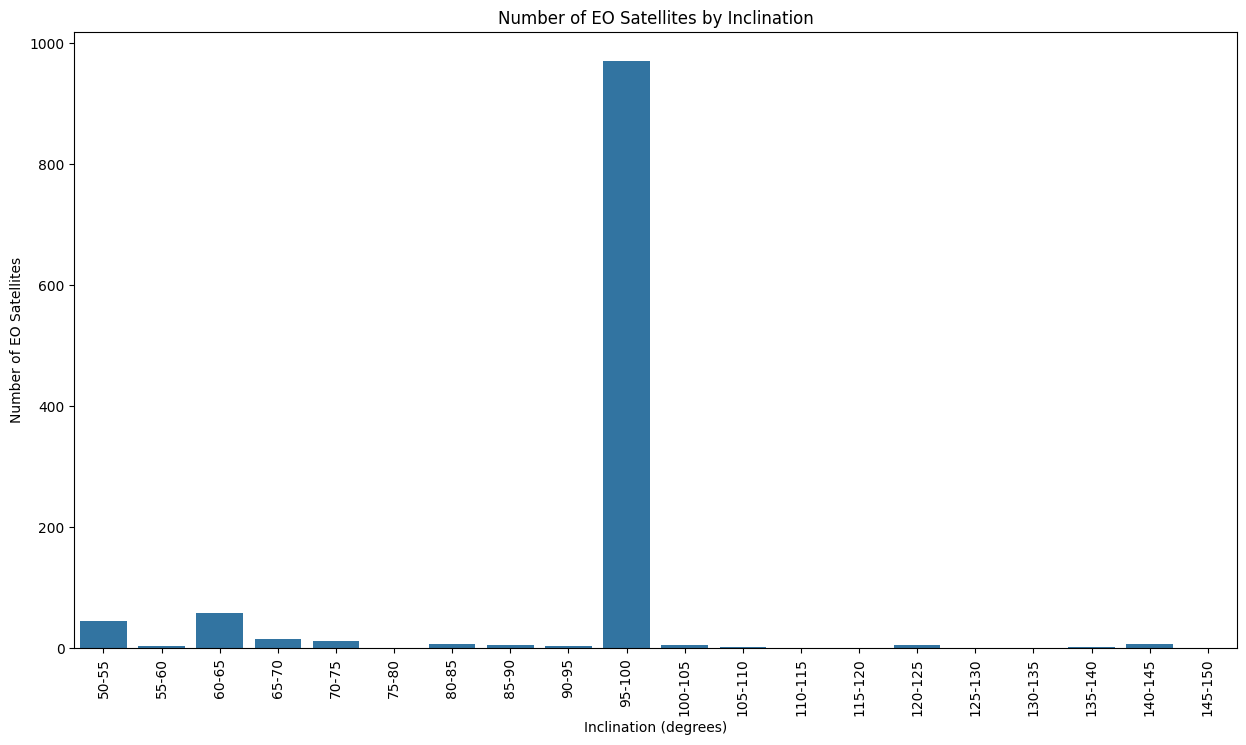

In [28]:
# Filter the data
filtered_df = df[(df['Inclination (degrees)'] >= 50) & (df['Inclination (degrees)'] <= 150)]

# Create a new column for binned inclination
filtered_df['Inclination Binned'] = pd.cut(filtered_df['Inclination (degrees)'], bins=range(50, 155, 5), 
                                           labels=[f'{i}-{i+5}' for i in range(50, 150, 5)])

# Count the number of satellites in each bin
counts = filtered_df['Inclination Binned'].value_counts().sort_index().reset_index()
counts.columns = ['Inclination (degrees)', 'Number of Satellites']

# Plot a bar chart
plt.figure(figsize=(15, 8))
sns.barplot(x='Inclination (degrees)', y='Number of Satellites', data=counts)
plt.xlabel('Inclination (degrees)')
plt.ylabel('Number of EO Satellites')
plt.title('Number of EO Satellites by Inclination')
plt.xticks(rotation=90)
plt.savefig('eo_satellites_by_inclination.png')
plt.show()

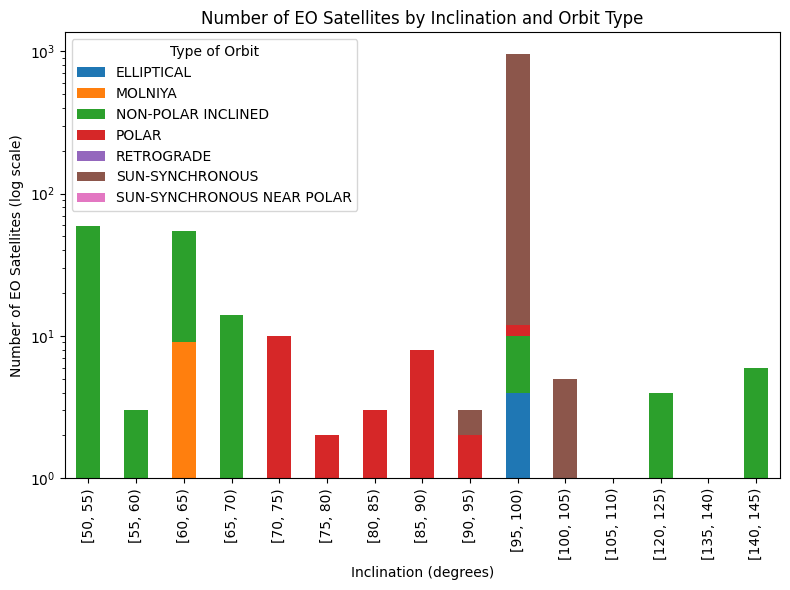

In [29]:
# Create a cross-tabulation of the number of satellites in each 'Type of Orbit' for each inclination bin
df['Inclination Binned'] = pd.cut(df['Inclination (degrees)'], bins=range(50, 150, 5), right=False)
cross_tab = pd.crosstab(index=df['Inclination Binned'], columns=df['Type of Orbit'])

# Plot a stacked bar chart
cross_tab.plot(kind='bar', stacked=True, figsize=(8,6), width=0.5)
plt.xlabel('Inclination (degrees)')
plt.ylabel('Number of EO Satellites (log scale)')
plt.title('Number of EO Satellites by Inclination and Orbit Type')
plt.yscale('log')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('eo_satellites_by_inclination_and_orbit_type.png')
plt.show()